In [1]:
from fenics import *
import numpy as np
from mpmath import findroot

In [55]:
# --- User choice: 'iso' or 'ortho' ---
material_type = 'iso'  # 'iso' for isotropic, 'ortho' for orthotropic

# Geometry parameters (mm)
J1S, J1L = 15.0, 23.0    # left clamp lengths
J2S, J2L = 15.0, 23.0    # right clamp lengths
gauge    = 30.0          # central gauge length
w        = 20.0          # specimen height
t        =  2.3          # thickness depth
Xmax     = gauge + J1L + J2L  # total length

# Material parameters (converted to N/mm^2)
if material_type == 'iso':
    E   = 52e3      # GPa->N/mm^2
    nu  = 0.3
    G   = 20e3
    F_target = -2544.0
    # isotropic plane stress stiffness factors
    def sigma_tensor(u):
        eps = sym(nabla_grad(u))
        return as_tensor([
            [E/(1-nu**2)*(eps[0,0] + nu*eps[1,1]), E/(1+nu)*eps[0,1]],
            [E/(1+nu)*eps[1,0],             E/(1-nu**2)*(eps[1,1] + nu*eps[0,0])]
        ])

elif material_type == 'ortho':
    Q11, Q22, Q12, Q66 = 41e3, 10.3e3, 3.1e3, 4e3
    F_target = -702.0
    # orthotropic plane stress
    def sigma_tensor(u):
        eps = sym(nabla_grad(u))
        return as_tensor([
            [Q11*eps[0,0] + Q12*eps[1,1],         2*Q66*eps[0,1]],
            [2*Q66*eps[1,0],                 Q12*eps[0,0] + Q22*eps[1,1]]
        ])
else:
    raise ValueError("material_type must be 'iso' or 'ortho'.")

# Mesh and function space
# dnx, dny = 330, 100
dnx, dny = 165, 50

mesh = RectangleMesh(Point(0,0), Point(Xmax, w), dnx, dny)
V = VectorFunctionSpace(mesh, 'P', 1)
d = mesh.topology().dim()
n = FacetNormal(mesh)

# Unknown clamp displacement
U = Constant(0.0)

tol = 1e-8
# boundary selectors
def bot_left(x, on):    return on and near(x[1], 0, tol) and x[0] <= (J1L + tol)
def top_left(x, on):    return on and near(x[1], w, tol) and x[0] <= (J1S + tol)
def bot_right(x, on):   return on and near(x[1], 0, tol) and x[0] >= (Xmax - J2S - tol)
def top_right(x, on):   return on and near(x[1], w, tol) and x[0] >= (Xmax - J2L - tol)
def left_corner(x,on):  return on and near(x[0], 0, tol) and near(x[1], 0, tol)

# Boundary conditions
bcs = []
bcs.append(DirichletBC(V.sub(0), Constant(0.0), left_corner))
bcs.append(DirichletBC(V.sub(1), Constant(0.0), bot_left))
bcs.append(DirichletBC(V.sub(1), Constant(0.0), top_left))
bcs.append(DirichletBC(V.sub(1), U,           bot_right))
bcs.append(DirichletBC(V.sub(1), U,           top_right))
# bcs.append(DirichletBC(V.sub(0), Constant(0.0), bot_left))
# bcs.append(DirichletBC(V.sub(0), Constant(0.0), top_left))
# bcs.append(DirichletBC(V.sub(0), Constant(0.0), bot_right))
# bcs.append(DirichletBC(V.sub(0), Constant(0.0), top_right))

# Variational form
u = TrialFunction(V)
v = TestFunction(V)
a = inner(sigma_tensor(u), sym(nabla_grad(v))) * dx
L = dot(Constant((0,0)), v) * dx

uh = Function(V)
# Mark right clamps for reaction
dim = mesh.topology().dim()
facets = MeshFunction('size_t', mesh, dim-1, 0)
AutoSubDomain(bot_right).mark(facets, 1)
AutoSubDomain(top_right).mark(facets, 2)
ds = Measure('ds', domain=mesh, subdomain_data=facets)

# Reaction force function
def reaction():
    solve(a == L, uh, bcs)
    Rb = assemble(dot(sigma_tensor(uh)*n, as_vector((0,1))) * ds(1))
    Rt = assemble(dot(sigma_tensor(uh)*n, as_vector((0,1))) * ds(2))
    return float((Rb + Rt) * t)

# Root-finding for U
def fU(val):
    U.assign(val)
    return reaction() - F_target

U_sol = findroot(fU, 0.0)
# print(f"Found U = {U_sol:.6f} mm for material {material_type}")

# Final solve & post-process
U.assign(U_sol)
solve(a == L, uh, bcs)

# Compute stress and strain fields
tensor_space = TensorFunctionSpace(mesh, 'P', 1)
strain = project(sym(nabla_grad(uh)), tensor_space)
stress = project(sigma_tensor(uh), tensor_space)

Solving linear variational problem.
  *** Warning: Found no facets matching domain for boundary condition.
Solving linear variational problem.
  *** Warning: Found no facets matching domain for boundary condition.
Solving linear variational problem.
  *** Warning: Found no facets matching domain for boundary condition.
Solving linear variational problem.
  *** Warning: Found no facets matching domain for boundary condition.
Solving linear variational problem.
  *** Warning: Found no facets matching domain for boundary condition.
Solving linear variational problem.
  *** Warning: Found no facets matching domain for boundary condition.
Solving linear variational problem.
  *** Warning: Found no facets matching domain for boundary condition.
Solving linear variational problem.
  *** Warning: Found no facets matching domain for boundary condition.
Solving linear variational problem.
  *** Warning: Found no facets matching domain for boundary condition.
Solving linear variational problem.
 

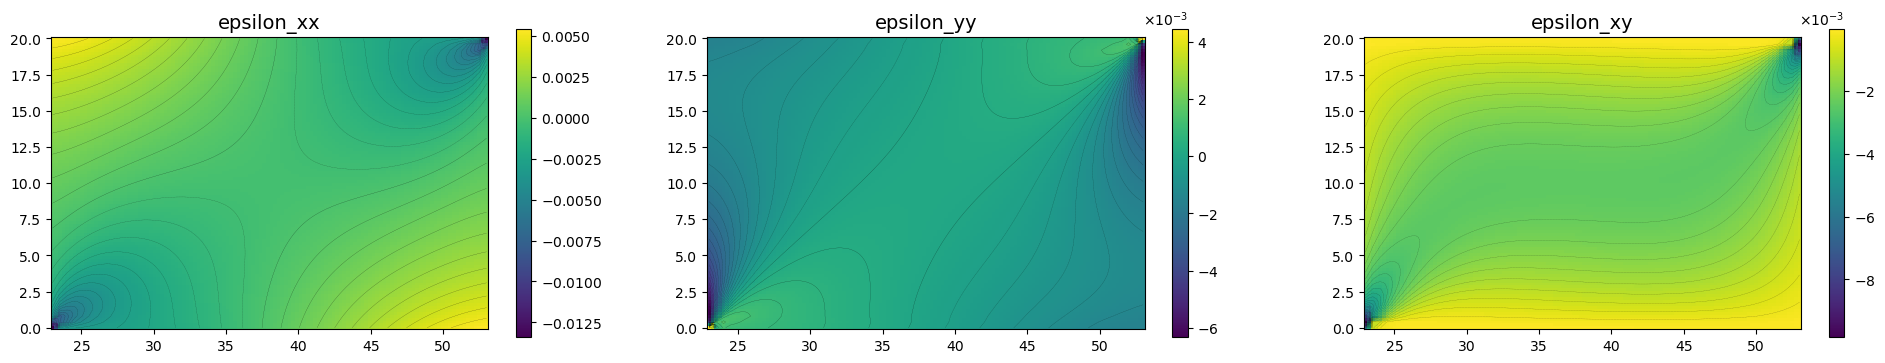

In [62]:
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt


def pcolor_plot(AX, X, Y, C, title, colormap="viridis", set_axis='on', colorbar=True, contour=True, n_levels=40, **kwargs):
    """
    Plots a pcolor plot with optional contour lines.
    
    Parameters:
        AX (matplotlib.axes): The axis to plot on.
        X, Y (2D array): Grid coordinates.
        C (2D array): Scalar field to plot.
        title (str): Plot title.
        colormap (str or Colormap): Colormap to use.
        set_axis (str): 'on' or 'off' to control axis visibility.
        colorbar (bool): Whether to display a colorbar.
        contour (bool): If True, adds contour lines.
        n_levels (int): Number of contour levels.
        kwargs: Optional `cmin` and `cmax` for color limits.
    """
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-3, 3))

    cmin = kwargs.get("cmin", None)
    cmax = kwargs.get("cmax", None)

    im = AX.pcolormesh(X, Y, C, cmap=colormap, shading='auto', vmin=cmin, vmax=cmax)

    if contour:
        levels = np.linspace(np.min(C) if cmin is None else cmin,
                             np.max(C) if cmax is None else cmax,
                             n_levels)
        AX.contour(X, Y, C, levels=levels, colors='k', linewidths=0.1)

    AX.set_aspect("equal", "box")
    AX.axis(set_axis)
    AX.set_title(title, fontsize=14)

    if colorbar:
        fig = AX.get_figure()
        fig.colorbar(im, ax=AX, format=formatter)

    return im

cmap = plt.get_cmap('viridis')
num_colors = 30
color_values = [cmap(i) for i in np.linspace(0, 1, num_colors)]
cmap = ListedColormap(color_values)
cmap = "viridis"

n_plot = (120, 100)
full_region = False

x_plot = np.linspace(0, Xmax, n_plot[0]) if full_region else np.linspace(J1L, J1L + gauge, n_plot[0])
y_plot = np.linspace(0, w, n_plot[1])
X, Y = np.meshgrid(x_plot, y_plot)

X_grid = np.hstack((X.flatten()[:, None], Y.flatten()[:, None]))

u_val = np.array([u_h(X_grid[i, :]) for i in range(X_grid.shape[0])])
strain_val = np.array([strain(X_grid[i, :]) for i in range(X_grid.shape[0])])
strain_val = np.array([strain_val[:,0], strain_val[:,3], 0.5*(strain_val[:,1]+strain_val[:,2])]).T
stress_val = np.array([stress(X_grid[i, :]) for i in range(X_grid.shape[0])])
stress_val = np.array([stress_val[:,0], stress_val[:,3], 0.5*(stress_val[:,1]+stress_val[:,2])]).T

# # Plot displacement
# fig, ax = plt.subplots(1, 2, figsize=(16, 4))
# im = pcolor_plot(ax[0], X, Y, u_val[:,0].reshape(X.shape), "u_x",colormap=cmap)
# im = pcolor_plot(ax[1], X, Y, u_val[:,1].reshape(X.shape), "u_y",colormap=cmap)

# # Plot strain
fig, ax = plt.subplots(1, 3, figsize=(24, 4))
im = pcolor_plot(ax[0], X, Y, strain_val[:,0].reshape(X.shape), "epsilon_xx",colormap=cmap)
im = pcolor_plot(ax[1], X, Y, strain_val[:,1].reshape(X.shape), "epsilon_yy",colormap=cmap)
im = pcolor_plot(ax[2], X, Y, strain_val[:,2].reshape(X.shape), "epsilon_xy",colormap=cmap)

# Plot stress
# fig, ax = plt.subplots(1, 3, figsize=(24, 4))
# im = pcolor_plot(ax[0], X, Y, stress_val[:,0].reshape(X.shape), "sigma_xx",colormap=cmap)
# im = pcolor_plot(ax[1], X, Y, stress_val[:,1].reshape(X.shape), "sigma_yy",colormap=cmap)
# im = pcolor_plot(ax[2], X, Y, stress_val[:,2].reshape(X.shape), "sigma_xy",colormap=cmap)

plt.show()


## Compare with VFM book

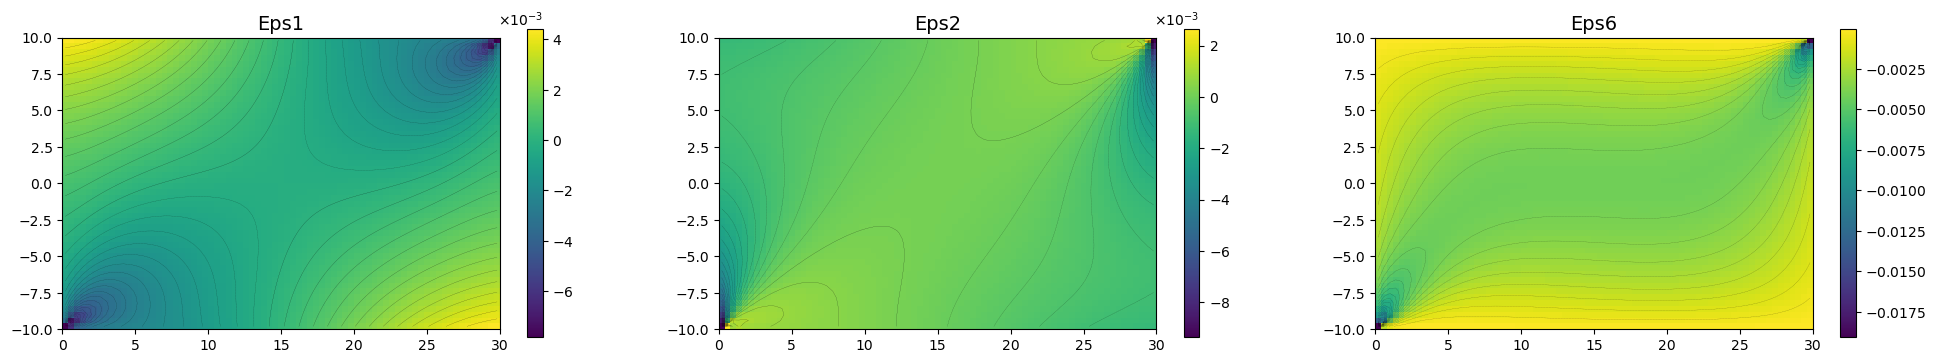

In [ ]:
from scipy.io import loadmat

# Load the data
data = loadmat('data/Iosipescu_isotropic.mat')
X1 = data['X1']
X2 = data['X2']
L = float(data['L'].item())
w = float(data['w'].item())
t = float(data['t'].item())
F = float(data['F'].item())
Eps1 = data['Eps1']
Eps2 = data['Eps2']
Eps6 = data['Eps6']


Eps1_fem = np.array([strain([X1[i, j]+J1L, X2[i, j]-10])[0] for i in range(X1.shape[0]) for j in range(X1.shape[1])]).reshape(X1.shape)
Eps2_fem = np.array([strain([X1[i, j]+J1L, X2[i, j]]-10)[1] for i in range(X1.shape[0]) for j in range(X1.shape[1])]).reshape(X1.shape)
Eps6_fem = np.array([strain([X1[i, j]+J1L, X2[i, j]]-10)[3] for i in range(X1.shape[0]) for j in range(X1.shape[1])]).reshape(X1.shape)

# Plot the data
fig, ax = plt.subplots(1, 3, figsize=(24, 4))
im = pcolor_plot(ax[0], X1, X2, Eps1, "Eps1",colormap=cmap)
im = pcolor_plot(ax[1], X1, X2, Eps2, "Eps2",colormap=cmap)
im = pcolor_plot(ax[2], X1, X2, Eps6, "Eps6",colormap=cmap)
plt.show()

# Plot residuals
# fig, ax = plt.subplots(1, 3, figsize=(24, 4))
# im = pcolor_plot(ax[0], X1, X2, Eps1 - Eps1_fem, "Eps1 - Eps1_fem",colormap="coolwarm")
# im = pcolor_plot(ax[1], X1, X2, Eps2 - Eps2_fem, "Eps2 - Eps2_fem",colormap="coolwarm")
# im = pcolor_plot(ax[2], X1, X2, Eps6 - Eps6_fem, "Eps6 - Eps6_fem",colormap="coolwarm")
# plt.show()


In [76]:
print(X1.shape)
(i,j) = 20, 20
strain([X1[i, j]+J1L, X2[i, j]])

(50, 75)


array([-0.00184311, -0.0006885 , -0.0006885 ,  0.00056112])